Name : Gandluru Mohammed Yaseen  
Reg.No : 12409548  
M.Tech specialized in AI and ML  
Lovely Professional University  
Mobile: 8328377285  
mail : gandlurumohammedyaseen@gmail.com  
LinkedIn: [yaseeng-md](https://www.linkedin.com/in/yaseeng-md/)  
GitHub: [yaseeng-md](http://www.github.com/yaseeng-md)


# Install Libraries and Import them 

#### Install Librabries using pip

In [ ]:
!pip install -q transformers evaluate datasets jiwer

In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr

In [ ]:
!pip install pytesseract

#### Check the GPU 

In [5]:
!nvidia-smi

Fri May 16 07:52:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Connect to Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import libraries

In [ ]:
# Standard libraries
import os
import cv2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# Kaggle & logging
import wandb
from kaggle_secrets import UserSecretsClient

# PyTorch
import torch
from torch.utils.data import Dataset

# Hugging Face
from evaluate import load
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Kaggle Login In CoLab Notebook

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


# Download the Dataset

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

naderabdalghani_iam_handwritten_forms_dataset_path = kagglehub.dataset_download('naderabdalghani/iam-handwritten-forms-dataset')
yaseeng_compressed_data_path = kagglehub.dataset_download('yaseeng/compressed-data')

print('Data source import complete.')


100%|██████████| 15.2M/15.2M [00:00<00:00, 62.7MB/s]

Extracting files...
Data source import complete.


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

# Global Variables

In [12]:
datasetPath = r"/kaggle/input/iam-handwritten-forms-dataset/data"
imageSize = (384,384)
epochs = 10
learningRate = 5e-5
batchSize = 8
validationSplit = 0.1

In [ ]:
img = cv2.imread("/kaggle/input/iam-handwritten-forms-dataset/data/000/a01-000u.png",0)
img.shape

(3542, 2479)

# Preprocessing

#### Crops the printed label (OCR region) from the image and returns the extracted text.

In [ ]:
def extractLabel(img):
    """
    Crops the printed label (OCR region) from the image and returns the extracted text.
    """
    labelCrop = img[360:660, 330:2130]
    labelText = pytesseract.image_to_string(labelCrop)
    labelText = labelText.strip().replace("\n", " ").replace("\x0c", "")
    return labelText
labelText = extractLabel(img)
print("The Extracted text from print is:\n",labelText.strip())
# cv2.imshow("Printed Text",labelCrop)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

The Extracted text from print is:
 A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is t be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put dow. a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P fo Manchester Exchange.


#### Crops and resizes the handwritten portion of the image.


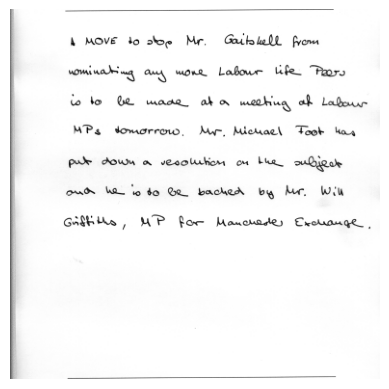

In [ ]:
def extractHandwritten(img, size=(384, 384)):
    """
    Crops and resizes the handwritten portion of the image.
    """
    handwrittenCrop = img[600:2800, 0:2479]
    handwrittenResized = cv2.resize(handwrittenCrop, size, interpolation=cv2.INTER_AREA)
    return handwrittenResized
handwrittenResized = extractHandwritten(img)
plt.imshow(handwrittenResized, cmap='gray')
plt.axis('off')
plt.show()


#### Apply CLAHE

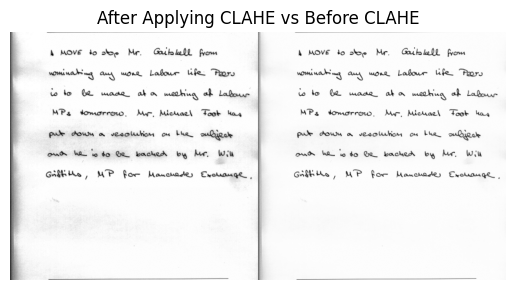

In [ ]:
def apply_clahe(gray_img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray_img)
    return enhanced
enhanced = apply_clahe(handwrittenResized)
res_clahe = np.hstack((enhanced,handwrittenResized))
plt.imshow(res_clahe, cmap='gray')
plt.title("After Applying CLAHE vs Before CLAHE")
plt.axis('off')
plt.show()

#### Sharpen Image

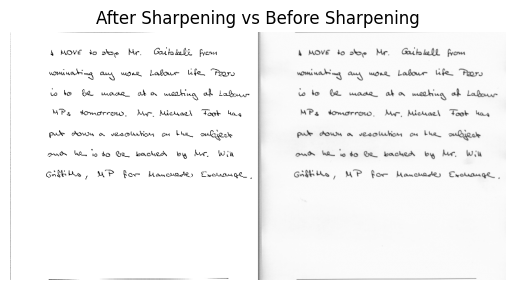

In [ ]:
def sharpen_image(gray_img):
    kernel = np.array([[0, -1, 0],
                       [-1, 6,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(gray_img, -1, kernel)
    return sharpened
sharpened = sharpen_image(handwrittenResized)
res_sharp = np.hstack((sharpened,handwrittenResized))
plt.imshow(res_sharp, cmap='gray')
plt.title("After Sharpening vs Before Sharpening")
plt.axis('off')
plt.show()

#### Use them in one function

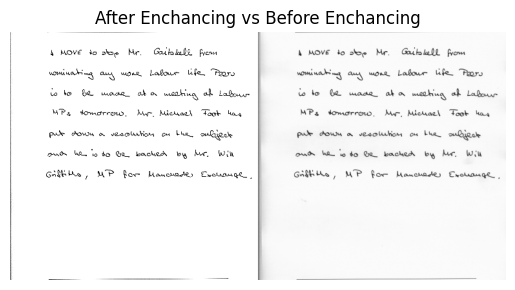

In [ ]:
def enhance_handwritten_image(gray_img):
    clahe_img = apply_clahe(gray_img)
    sharp_img = sharpen_image(clahe_img)
    return sharp_img
sharp_img = enhance_handwritten_image(handwrittenResized)
res_enhanced = np.hstack((sharp_img,handwrittenResized))
plt.imshow(res_enhanced, cmap='gray')
plt.title("After Enchancing vs Before Enchancing")
plt.axis('off')
plt.show()

# Dataset Creation

In [ ]:
def create_dataset(path):
    images, labels = [], []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            img_path = Path(folder_path) / file
            img = cv2.imread(str(img_path), 0)
            if img is None:
                continue

            label = extractLabel(img)
            handwritten = extractHandwritten(img)
            enhanced = enhance_handwritten_image(handwritten)

            images.append(enhanced)
            labels.append(label)

    return np.array(images), np.array(labels)


In [14]:
class TrOCRHandwritingDataset(Dataset):
    """
    Custom PyTorch Dataset for preparing handwriting images and text labels
    compatible with the TrOCR model.

    This dataset:
    - Accepts grayscale images as numpy arrays and their corresponding text labels.
    - Converts images to RGB PIL format and processes them with TrOCRProcessor.
    - Tokenizes the text labels and masks padding tokens for loss calculation.

    Args:
        image_arrays (List[np.ndarray]): List of grayscale images as numpy arrays of shape (H, W).
        labels (List[str]): Corresponding list of ground-truth text strings.
        processor (TrOCRProcessor): Hugging Face processor combining feature extractor and tokenizer.
        max_target_length (int, optional): Maximum token length for labels; defaults to 128.

    Methods:
        __len__():
            Returns the total number of samples.
        __getitem__(idx):
            Returns the processed image tensor and tokenized label for the sample at index `idx`.

    Returns from __getitem__:
        dict:
            - 'pixel_values' (torch.Tensor): Image tensor of shape (3, 384, 384).
            - 'labels' (torch.Tensor): Tokenized label tensor with padding tokens masked as -100.
    """
    def __init__(self, image_arrays, labels, processor, max_target_length=128):
        self.images = image_arrays
        self.labels = labels
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        text = self.labels[idx]

        # Normalize image pixels if in [0,1] range and convert to uint8
        if image.max() <= 1.0:
            image = (image * 255).astype("uint8")

        # Convert grayscale numpy array to RGB PIL image
        pil_image = Image.fromarray(image).convert("RGB")

        # Process image to pixel values tensor
        pixel_values = self.processor(images=pil_image, return_tensors="pt").pixel_values.squeeze()

        # Tokenize text label with padding and truncation
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True
        ).input_ids

        # Replace tokenizer padding token ID with -100 to ignore during loss computation
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        return {
            "pixel_values": pixel_values,    
            "labels": torch.tensor(labels)   
        }


#### Created the dataset

In [ ]:
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# images, labels = create_dataset(datasetPath)

#### Save locally for futher use

In [ ]:
# np.save("images.npy",images)
# np.save("labels.npy",labels)

#### Load saved files for faster excecution

In [6]:
dataset = np.load("/content/drive/MyDrive/trocr_dataset.npz")
images = dataset["images"]
labels = dataset["labels"]

#### Train test Split for training dataset and test dataset

In [8]:
from sklearn.model_selection import train_test_split
images_train,images_test,labels_train,labels_test = train_test_split(images,labels,test_size=0.1)
print(f"Training Instances : {images_train.shape[0]}")
print(f"Testing Instaances : {images_test.shape[0]}")

Training Instances : 1385
Testing Instaances : 154


#### Process the dataset according to TrOCR Requirements

In [15]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
train_dataset = TrOCRHandwritingDataset(image_arrays = images_train, labels = labels_train,processor = processor)
test_dataset = TrOCRHandwritingDataset(image_arrays = images_test, labels = labels_test,processor = processor)


#### Final Image

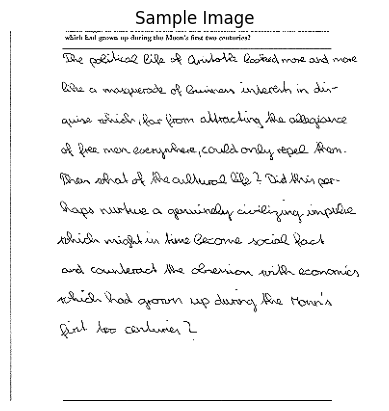

In [ ]:
sample = train_dataset[0]
img_tensor = sample["pixel_values"]
img_np = img_tensor.permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(img_np)
plt.axis("off")
plt.title("Sample Image")
plt.show()

#### Define Model

In [16]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Model Configaration and Hyper Parameters

In [23]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True,
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)


#### Define Metrics

In [19]:
import evaluate
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [20]:
def compute_metrics(eval_preds):
    pred_ids, label_ids = eval_preds
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}


#### Model Training

In [24]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-24-f311102b0162>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Cer,Wer
200,7.088000,7.153903,0.803306,0.961711
400,6.766900,7.006516,0.730822,0.929986
600,6.873400,6.922461,0.918155,0.991686
800,6.333500,6.807699,0.780509,0.942676
1000,5.541700,6.616583,0.755617,0.955585
1200,5.934300,6.495584,0.834906,1.017832
1400,6.542800,6.478633,0.769399,0.965321
1600,5.345100,6.439676,0.777030,0.976589
1800,5.974200,6.423919,0.782739,0.997484
2000,5.303600,6.357996,0.741720,0.958976


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=3470, training_loss=5.661671379182799, metrics={'train_runtime': 6338.0414, 'train_samples_per_second': 2.185, 'train_steps_per_second': 0.547, 'total_flos': 1.860936359875707e+19, 'train_loss': 5.661671379182799, 'epoch': 10.0})

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
    

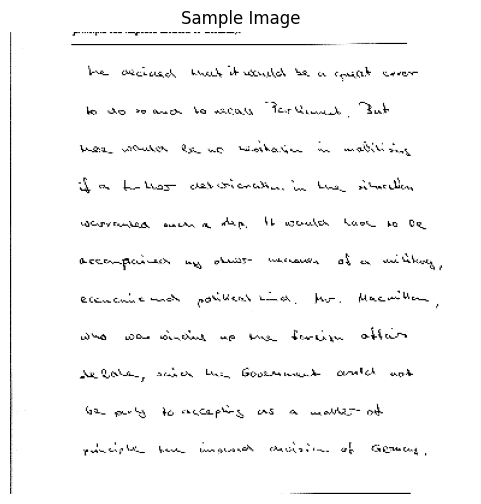

📝 Predicted Text:
 Mr William (ris is insensitive pushing Miss Allen wife pale appealing Miss Allen his, pale appealing always appealing Mr Aub Richards the, editor alwaysicallyashed the, com ab by events and.rey, com grotesque the---, wereashed the-, Mr James, fatherinlaw alwaysically; com grotesque they


In [26]:
sample = train_dataset[0]
img_tensor = sample["pixel_values"].unsqueeze(0).to(device)  # Add batch dimension and move to GPU/CPU

# Step 2: Display the image
img_np = img_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.axis("off")
plt.title("Sample Image")
plt.show()

# Step 3: Run inference using the fine-tuned model
model.eval()
with torch.no_grad():
    generated_ids = model.generate(img_tensor)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Step 4: Display predicted output
print("📝 Predicted Text:\n", predicted_text)
